# BVA Figures for FRETBursts Paper


*This notebook generates the BVA figures for the paper:*

<br>
<div class="alert alert-success">
<b>FRETBursts: Open Source Burst Analysis Toolkit for Confocal Single-Molecule FRET</b><br>
Ingargiola et al. (2016). biorXiv doi:<a href="http://dx.doi.org/10.1101/039198" target="_blank">10.1101/039198</a>
</div>

> The main notebook is: [FRETBursts Paper Main Notebook](FRETBursts Paper Main Notebook.ipynb)

# Loading software

Load software and define default figure style.

In [1]:
from fretbursts import *
sns = init_notebook()

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.5.5).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1101/039198 

--------------------------------------------------------------


In [ ]:
savefig_kws = dict(dpi=200, bbox_inches='tight')

# Download and load the data

In [2]:
url = 'http://files.figshare.com/4858417/HairPin3_RT_400mM_NaCl_A_31_TA.hdf5'
download_file(url, save_dir='./data')

URL:  http://files.figshare.com/4858417/HairPin3_RT_400mM_NaCl_A_31_TA.hdf5
File: HairPin3_RT_400mM_NaCl_A_31_TA.hdf5
 
File already on disk: /Users/anto/src/fretbursts_paper/notebooks/data/HairPin3_RT_400mM_NaCl_A_31_TA.hdf5 
Delete it to re-download.


In [3]:
url = 'http://files.figshare.com/4858420/20dA_20dT_200mMgCl2.hdf5'
download_file(url, save_dir='./data')

URL:  http://files.figshare.com/4858420/20dA_20dT_200mMgCl2.hdf5
File: 20dA_20dT_200mMgCl2.hdf5
 
File already on disk: /Users/anto/src/fretbursts_paper/notebooks/data/20dA_20dT_200mMgCl2.hdf5 
Delete it to re-download.


In [4]:
full_fname1 = 'data/20dA_20dT_200mMgCl2.hdf5'
full_fname2 = 'data/HairPin3_RT_400mM_NaCl_A_31_TA.hdf5'

In [5]:
d1 = loader.photon_hdf5(full_fname1)
d2 = loader.photon_hdf5(full_fname2)

# μs-ALEX parameters

Here we define and apply the alternation parameters. Note that these parameters
are already stored in the Photon-HDF5 files but can be overridden by the user:

#donor: 1243810  #acceptor: 1454459 



data_20dA_20dT_200mMgCl2 G1.000

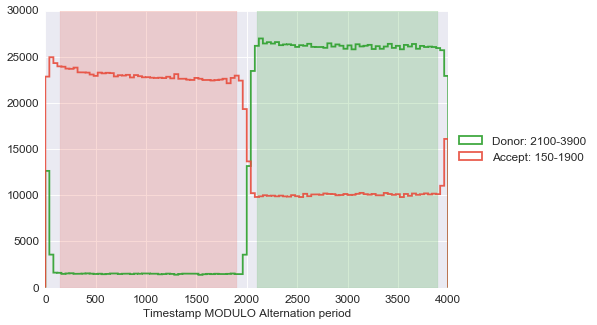

In [6]:
d1.add(det_donor_accept=(0, 1), 
      alex_period=4000, 
      D_ON=(2100, 3900), 
      A_ON=(150, 1900),
      offset=700)
bpl.plot_alternation_hist (d1)
loader.usalex_apply_period(d1)

#donor: 7062993  #acceptor: 13607681 



data_HairPin3_RT_400mM_NaCl_A_31_TA G1.000

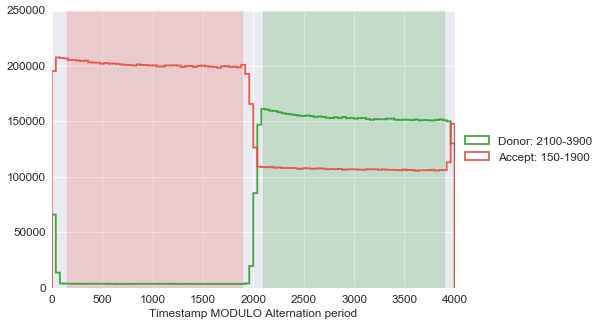

In [7]:
d2.add(det_donor_accept=(0, 1), 
      alex_period=4000, 
      D_ON=(2100, 3900), 
      A_ON=(150, 1900),
      offset=700)
bpl.plot_alternation_hist (d2)
loader.usalex_apply_period(d2)

# Compute background

In [8]:
d1.calc_bg(bg.exp_fit, time_s=50.1, tail_min_us='auto', F_bg=1.7)
d2.calc_bg(bg.exp_fit, time_s=50.1, tail_min_us='auto', F_bg=1.7)

 - Calculating BG rates ... [DONE]
 - Calculating BG rates ... [DONE]


# Burst  search and selection

For BVA we perform burst search on the Dex photon stream 
and compute the raw uncorrected E values:

In [9]:
d1.burst_search(m=10, computefret=False, ph_sel=Ph_sel(Dex='DAem'))
d1.calc_fret(count_ph=True, corrections=False)

 - Performing burst search (verbose=False) ... - Recomputing background limits for Dex ... [DONE]
 - Recomputing background limits for all ... [DONE]
 - Fixing  burst data to refer to ph_times_m ... [DONE]
[DONE]
 - Calculating burst periods ...[DONE]


In [10]:
d2.burst_search(m=10, computefret=False, ph_sel=Ph_sel(Dex='DAem'))
d2.calc_fret(count_ph=True, corrections=False)

 - Performing burst search (verbose=False) ... - Recomputing background limits for Dex ... [DONE]
 - Recomputing background limits for all ... [DONE]
 - Fixing  burst data to refer to ph_times_m ... [DONE]
[DONE]
 - Calculating burst periods ...[DONE]


Here we filter out D-only adn A-only populations:

In [11]:
ds1 = d1.select_bursts(select_bursts.naa, th1=30, computefret=False)
ds_1 = ds1.select_bursts(select_bursts.size, th1=30, computefret=False)
ds_FRET1 = ds_1.select_bursts(select_bursts.S, S1=0.25, S2=0.85, computefret=False)

In [12]:
ds2 = d2.select_bursts(select_bursts.naa, th1=70, computefret=False)
ds_2 = ds2.select_bursts(select_bursts.size, th1=70, computefret=False)
ds_FRET2 = ds_2.select_bursts(select_bursts.S, S1=0.25, S2=0.85, computefret=False)

Next, we save the E-S histograms for the two files:

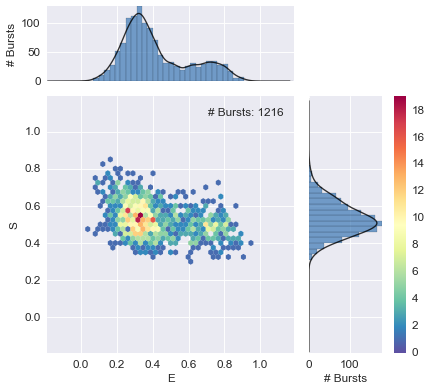

In [13]:
alex_jointplot(ds_FRET1)
plt.savefig('../figures/ALEX_static.png', **savefig_kws)

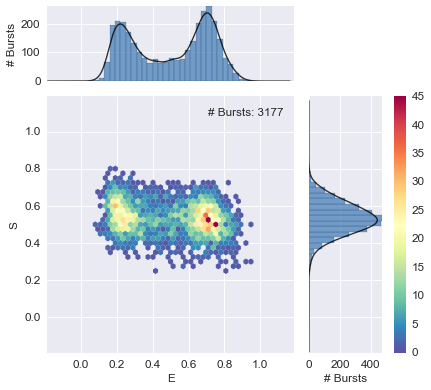

In [14]:
alex_jointplot(ds_FRET2)
plt.savefig('../figures/ALEX_dynamic.png', **savefig_kws)

# Burst Variance Analysis

For start, we define a function computing the BVA:

In [15]:
def bva_sigma_E(n, bursts_d, DexAem_mask_d):
    E_sub_std = []
    for burst in bursts_d:
        E_sub_bursts = []
        startlist = range(burst.istart, burst.istop + 2 - n, n)
        stoplist = [i + n for i in startlist]
        for start, stop in zip(startlist, stoplist):
            A_D = DexAem_mask_d[start:stop].sum()
            assert stop-start == n
            E = A_D / n
            E_sub_bursts.append(E)
        E_sub_std.append(np.std(E_sub_bursts))
    return np.array(E_sub_std)

## Static mixture: di-labeled 20dT + 20dA

Let's print the sample description:

In [16]:
d1.sample['sample_name']

'Static mixture of di-labeled 20dT and 20dA (partial hybridization). Room temperature.'

In [17]:
ph_d1 = ds_FRET1.get_ph_times(ph_sel=Ph_sel(Dex='DAem'))
bursts1 = ds_FRET1.mburst[0]
bursts_d1 = bursts1.recompute_index_reduce(ph_d1)

In [18]:
Dex_mask1 = ds_FRET1.get_ph_mask(ph_sel=Ph_sel(Dex='DAem'))   
DexAem_mask1 = ds_FRET1.get_ph_mask(ph_sel=Ph_sel(Dex='Aem')) 
DexAem_mask_d1 = DexAem_mask1[Dex_mask1]

In [19]:
n = 7
E_sub_std1 = bva_sigma_E(n, bursts_d1, DexAem_mask_d1)

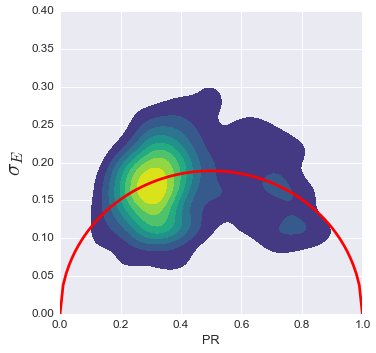

In [20]:
sns.set_style(style='darkgrid')
plt.figure(figsize=(6,6))
x = np.arange(0,1.01,0.01)
y = np.sqrt((x*(1-x))/n)
plt.plot(x,y, lw=3, color='red')
im = sns.kdeplot(ds_FRET1.E_, E_sub_std1, shade=True, cmap='viridis', shade_lowest=False, n_levels=9)
plt.xlim(0,1)
plt.ylim(0,0.4)
plt.xlabel('PR', fontsize=14)
plt.ylabel(r'$\sigma_E$', fontsize=24)
plt.savefig('../figures/BVA_static.png', **savefig_kws)

<div class="alert alert-warning">
To get the same KDE plot of the paper make sure that the package `statsmodels` is installed.
</div>

## Dynamics: Hairpin

Data: Hairpin construct $A_{31}-TA$ from [Tsukanov 2013](http://doi.org/10.1021/jp4059214).

In [21]:
d2.sample['sample_name']

'Hairpin (A_31-TA)'

In [22]:
ph_d2 = ds_FRET2.get_ph_times(ph_sel=Ph_sel(Dex='DAem'))
bursts2 = ds_FRET2.mburst[0]
bursts_d2 = bursts2.recompute_index_reduce(ph_d2)

In [23]:
Dex_mask2 = ds_FRET2.get_ph_mask(ph_sel=Ph_sel(Dex='DAem'))   
DexAem_mask2 = ds_FRET2.get_ph_mask(ph_sel=Ph_sel(Dex='Aem')) 
DexAem_mask_d2 = DexAem_mask2[Dex_mask2]

In [24]:
n = 7
E_sub_std2 = bva_sigma_E(n, bursts_d2, DexAem_mask_d2)

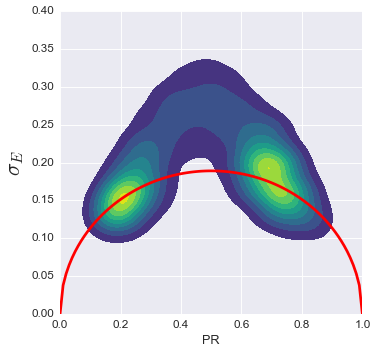

In [25]:
sns.set_style(style='darkgrid')
plt.figure(figsize=(6,6))
x=np.arange(0,1.01,0.01)
y=np.sqrt((x*(1-x))/n)
plt.plot(x,y, lw=3, color='red')
im = sns.kdeplot(ds_FRET2.E_, E_sub_std2, shade=True, cmap='viridis', shade_lowest=False)
plt.xlim(0,1)
plt.ylim(0,0.4)
plt.xlabel('PR', fontsize=14)
plt.ylabel(r'$\sigma_E$', fontsize=24)
plt.savefig('../figures/BVA_dynamic.png', **savefig_kws)

<div class="alert alert-warning">
To get the same KDE plot of the paper make sure that the package `statsmodels` is installed.
</div>

# Join the images

Finally, we simply join the images together to generate the final figures.

In [26]:
import sys
from IPython.display import display
from PIL import Image

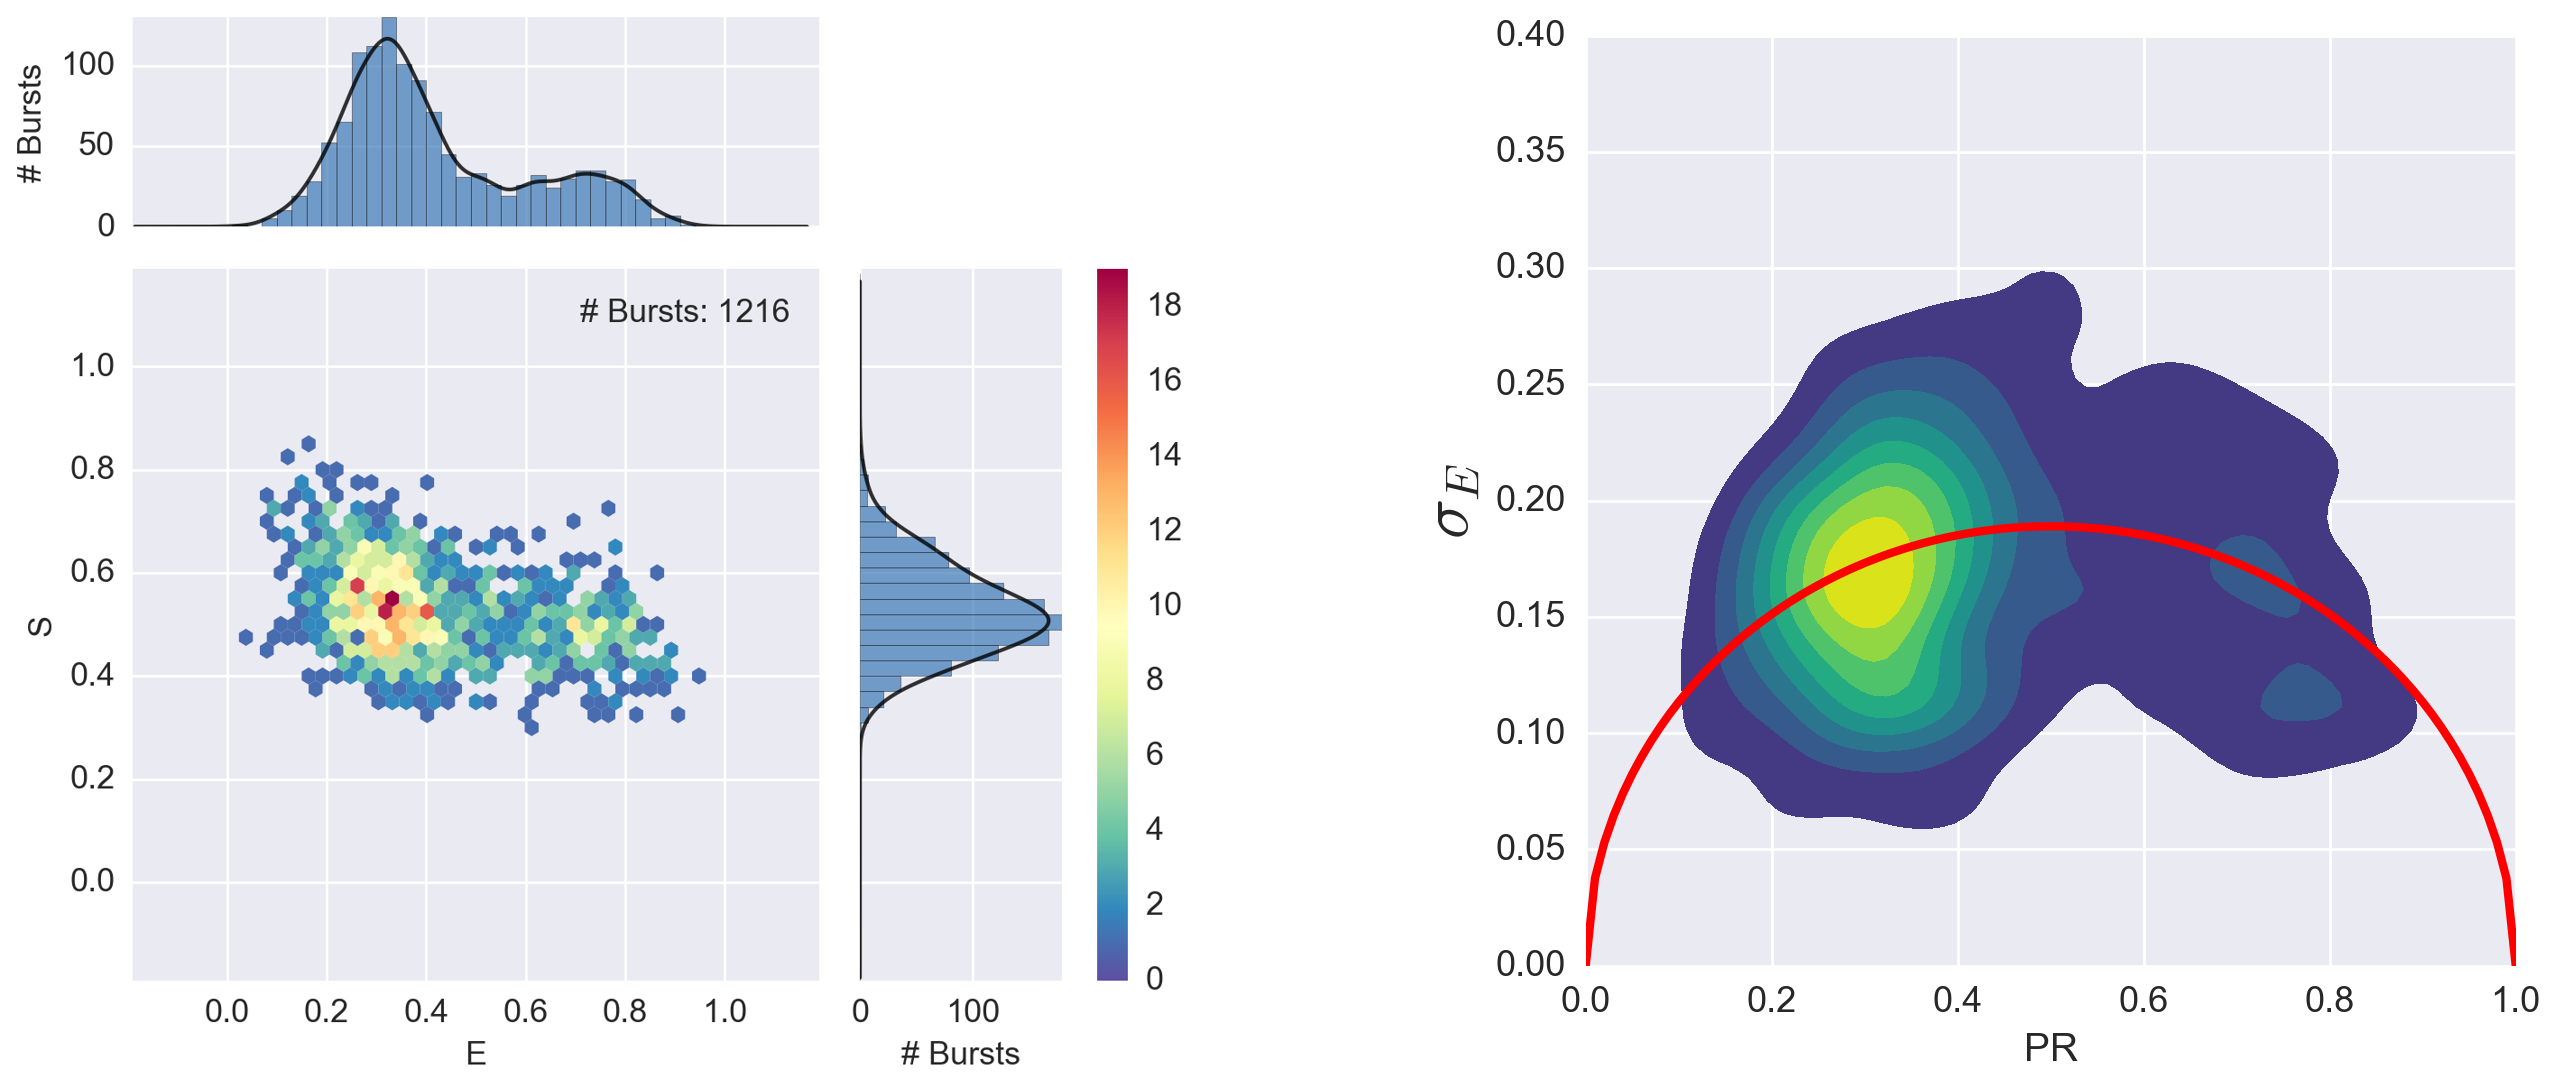

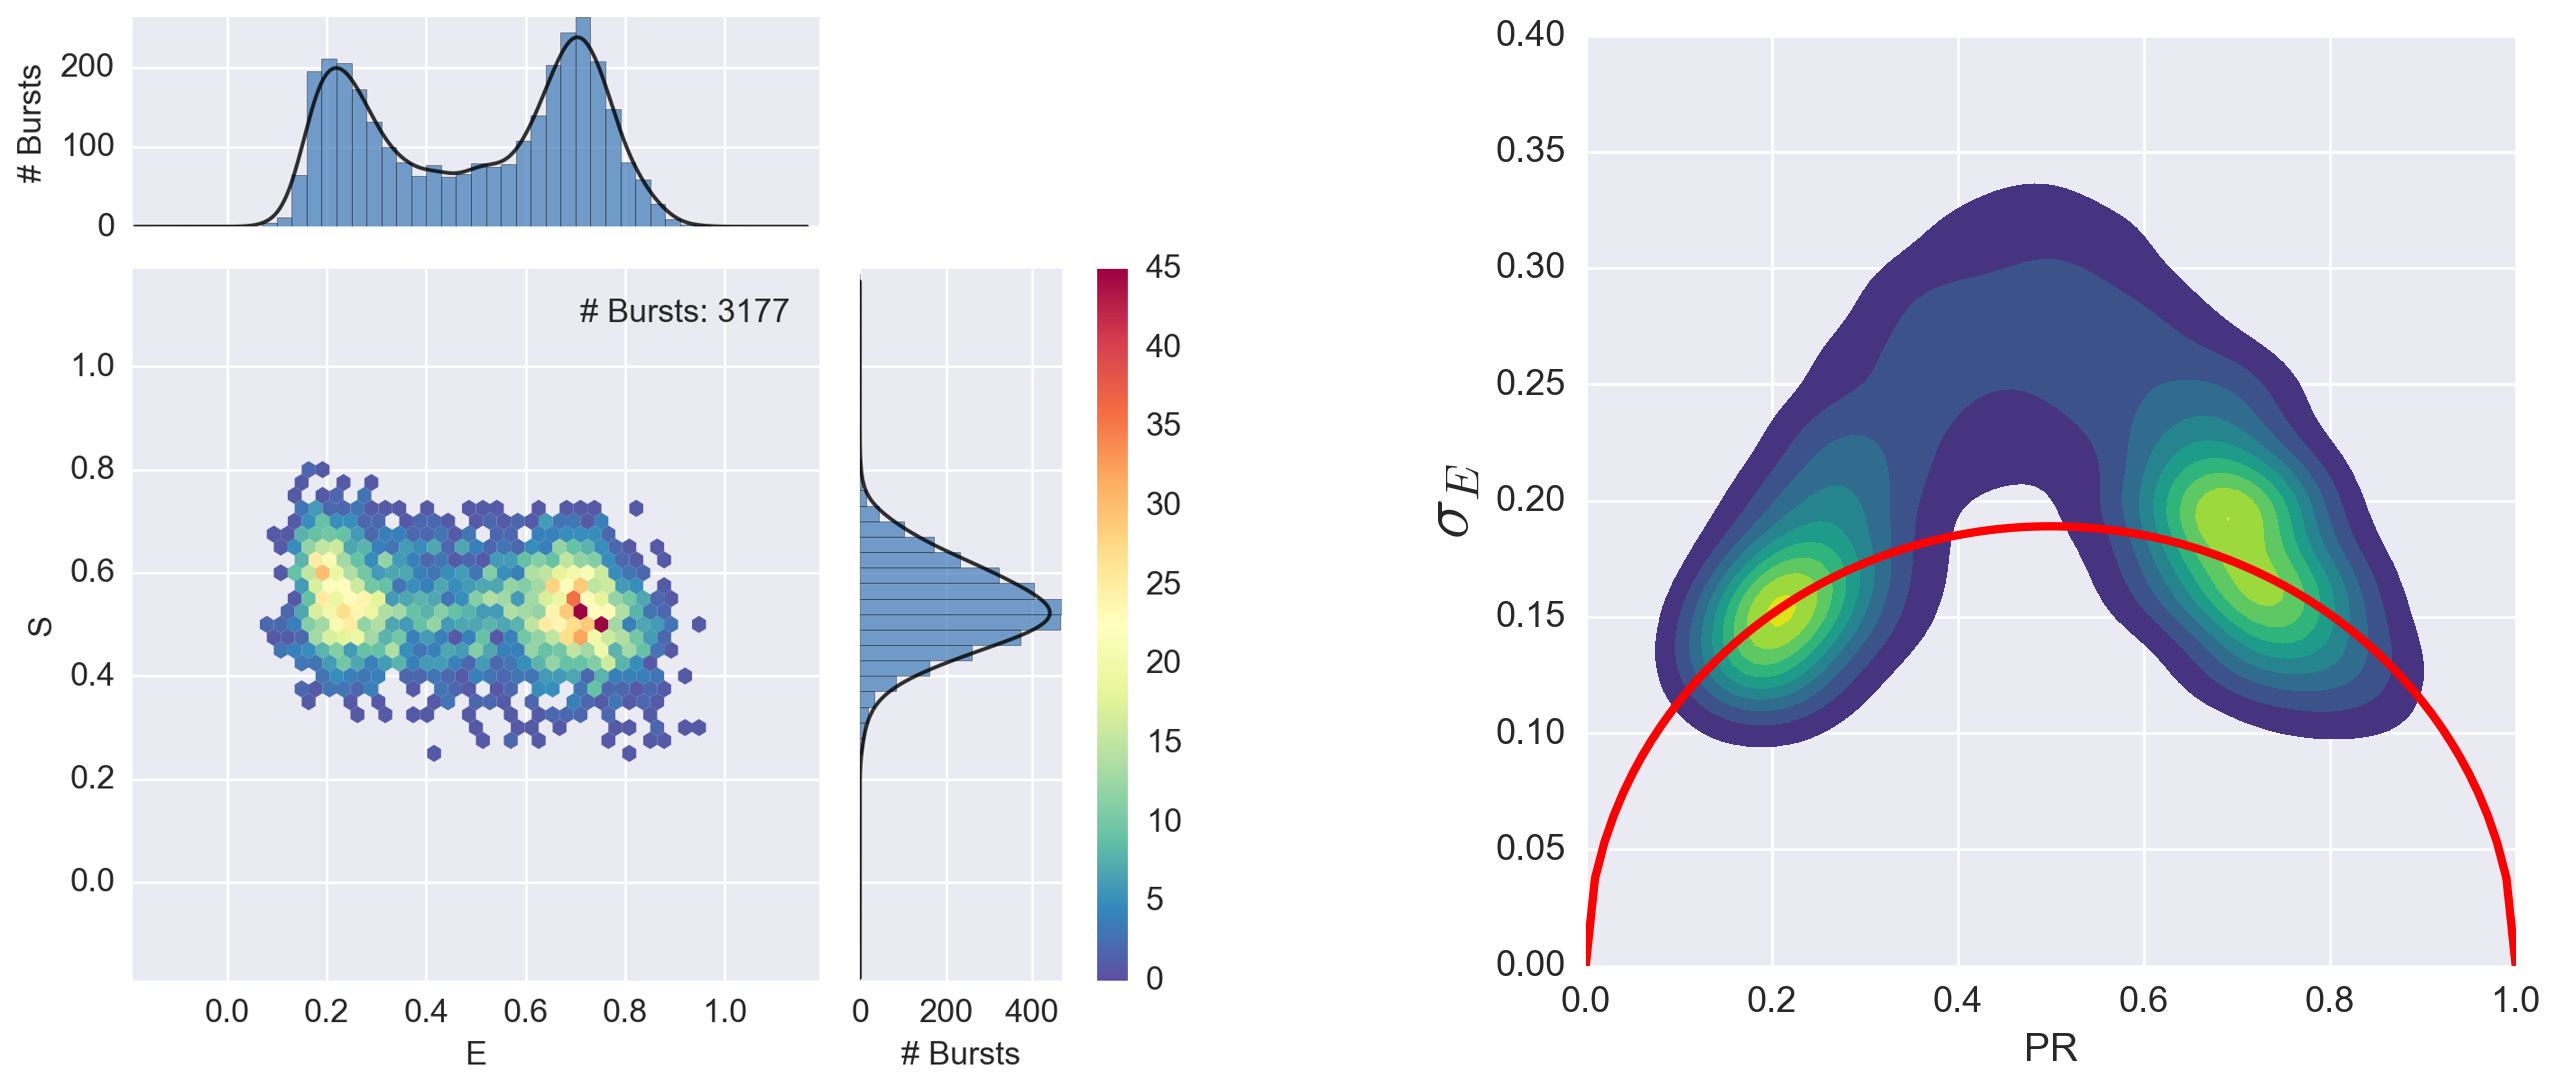

In [27]:
for label in ('static','dynamic'):
    ALEX= Image.open("../figures/ALEX_%s.png" % label)
    BVA = Image.open("../figures/BVA_%s.png" % label)
    ALEX.thumbnail((1200,1088))
    BVA.thumbnail((1160,1088))
    new_im = Image.new('RGBA', (2560,1088))
    im_list=[ALEX, BVA]
    j=0
    for im in im_list:
        new_im.paste(im, (j,0))
        j=j+1400

    new_im.save('../figures/ALEX_BVA_%s/ALEX_BVA_%s.png' % (label,label), bbox_inches='tight')
    display(new_im)